# Queue MLs vs NOS (zero-shot)
**NOTE**: This notebook imports NOS modules from src/. See the repository README section “Running notebooks” for setup.

Zero-shot next-step forecasting (no supervised training): MAE / AUROC / AUPRC
  Physics Fluid : MAE=0.6748, AUROC=0.834, AUPRC=0.555
  Moving Avg    : MAE=0.8782, AUROC=0.552, AUPRC=0.194
  TGNN-smooth   : MAE=0.9251, AUROC=0.507, AUPRC=0.128
  LIF-leaky     : MAE=0.8891, AUROC=0.500, AUPRC=0.126
  NOS zero-shot : MAE=0.9278, AUROC=0.894, AUPRC=0.536
[NOS calibration] gain_I=0.600
[NOS calibration] first 3 per-node scales: [11.646 12.226 12.277]
[Analytic low-load L] first 3 nodes: [0.655 0.738 0.745]


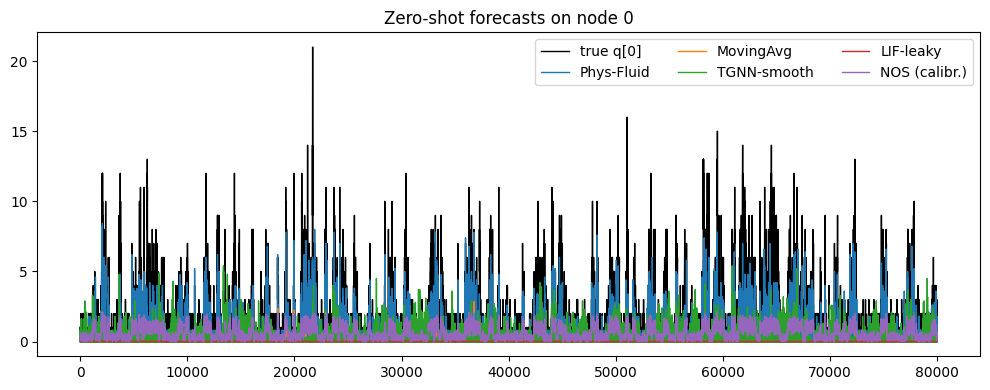

In [ ]:

"""
Zero-shot forecasters vs NOS

Purpose
- Compare simple, label-free forecasters against NOS as a congestion/occupancy proxy.
- All methods are unsupervised: no supervised fitting, no labels used for training.
Notes:
- The default NOS usage here is a *window embedding*: v,u are reset for each window and rolled forward over the window.
  This matches the original script. For a persistent dynamical NOS proxy, set `NOS_STATEFUL = True`.
"""

from __future__ import annotations

import os
import sys
import json
import inspect
from pathlib import Path
from dataclasses import dataclass

import numpy as np
import matplotlib.pyplot as plt

try:
    from sklearn.metrics import roc_auc_score, average_precision_score
except Exception:  # pragma: no cover
    roc_auc_score = None
    average_precision_score = None


SEED_MAIN = 0
rng = np.random.default_rng(SEED_MAIN)

OUTDIR = os.path.join("outputs", "queue_mls_vs_nos")
os.makedirs(OUTDIR, exist_ok=True)
SAVE_FIGS = True

try:
    _HERE = Path(__file__).resolve().parent
except NameError:
    _HERE = Path.cwd()

if (_HERE / "src").exists():
    sys.path.insert(0, str(_HERE))
elif (_HERE.parent / "src").exists():
    sys.path.insert(0, str(_HERE.parent))

# NOS canonical import (optional)
NOSParams = None
NOSState = None
_nos_step_fn = None
try:
    import src.nos as _nos_mod
except Exception:
    try:
        import nos as _nos_mod
    except Exception:
        _nos_mod = None

if _nos_mod is not None:
    NOSParams = getattr(_nos_mod, "NOSParams", None)
    NOSState  = getattr(_nos_mod, "NOSState", None)

    if hasattr(_nos_mod, "nos_step_raw"):
        _nos_step_fn = _nos_mod.nos_step_raw
    elif hasattr(_nos_mod, "nos_step"):
        _nos_step_fn = _nos_mod.nos_step

# --------------------------
# Experiment configuration
# ----------------------------
T  = 4000       # seconds of steps
dt = 0.01
N  = 8
win = 20

# Behaviour toggles
NOS_STATEFUL = False         # False = reset v,u per window (original). True = persistent v,u across time.
LIF_USE_DT = True            # True reproduces original LIF baseline (arrival term uses gain*s*dt).
USE_SRC_NOS = True           # use src/nos.py if available; falls back to local otherwise.

CFG = dict(
    seed=SEED_MAIN, T=T, dt=dt, N=N, win=win,
    NOS_STATEFUL=NOS_STATEFUL,
    LIF_USE_DT=LIF_USE_DT,
    USE_SRC_NOS=USE_SRC_NOS,
)

# ----------------------------
# Data + ground truth (MMPP arrivals, M/M/1/K)
# ----------------------------
A = np.zeros((N, N), dtype=np.float32)
for i in range(N):
    A[i, (i-1) % N] = 1.0
    A[i, (i+1) % N] = 1.0

def gen_mmpp_matrix(T, dt, lam_lo, lam_hi, p_up=0.01, p_dn=0.01, N=8):
    """Simple MMPP-like burst process: lam toggles between lam_lo and lam_hi for random node subsets."""
    steps = int(T/dt)
    arr = np.zeros((steps, N), dtype=np.float32)
    lam  = np.full(N, lam_lo, dtype=np.float32)
    for t in range(steps):
        if rng.random() < p_up:
            idx = rng.choice(N, size=max(1, N//4), replace=False)
            lam[idx] = lam_hi
        if rng.random() < p_dn:
            idx = rng.choice(N, size=max(1, N//4), replace=False)
            lam[idx] = lam_lo
        arr[t] = rng.poisson(lam*dt).astype(np.float32)
    return arr

lam_lo, lam_hi = 20.0, 80.0
arr = gen_mmpp_matrix(T, dt, lam_lo, lam_hi, N=N)

mu_pps = 120.0
K      = 200

def step_mm1k_vector(q, a, mu, K, dt):
    """Vectorised M/M/1/K with Poisson service; a are arrivals-per-step counts."""
    admit  = np.minimum(a.astype(np.int32), np.maximum(K-q, 0))
    q      = q + admit
    served = np.minimum(q, rng.poisson(mu*dt, size=q.shape))
    q      = q - served
    return q

q_true = np.zeros((arr.shape[0], N), dtype=np.float32)
for t in range(arr.shape[0]-1):
    q_true[t+1] = step_mm1k_vector(q_true[t], arr[t], mu_pps, K, dt)

def build_windows(arr, q, win):
    X, y = [], []
    for t in range(win, arr.shape[0]):
        X.append(arr[t-win:t])  # [win,N]
        y.append(q[t])          # [N]
    return np.stack(X, 0).astype(np.float32), np.stack(y, 0).astype(np.float32)

X, y = build_windows(arr, q_true, win)        # [T',win,N], [T',N]
Tprime = X.shape[0]
i_tr = int(0.6*Tprime)
i_va = int(0.8*Tprime)
Xtr, Xva, Xte = X[:i_tr], X[i_tr:i_va], X[i_va:]
ytr, yva, yte = y[:i_tr], y[i_tr:i_va], y[i_va:]

# Unsupervised burst labels: 90th percentile on *train* per node
thr = np.percentile(ytr, 90.0, axis=0, keepdims=True)
ybin_te = (yte >= thr).astype(np.float32)

# ----------------------------
# Zero-shot baselines (no labels)
# ----------------------------
def physics_fluid_forecaster(X, mu_pps, K, dt):
    Tn, W, N = X.shape
    out = np.zeros((Tn, N), dtype=np.float32)
    qh  = np.zeros(N, dtype=np.float32)
    for t in range(Tn):
        a_last = X[t, -1, :]
        qh = np.clip(qh + a_last - mu_pps*dt, 0, K)
        out[t] = qh
    return out

def moving_average_forecaster(X, mu_pps, K, dt):
    Tn, W, N = X.shape
    out = np.zeros((Tn, N), dtype=np.float32)
    qh  = np.zeros(N, dtype=np.float32)
    for t in range(Tn):
        a_bar = X[t].mean(axis=0)
        qh = np.clip(qh + a_bar - mu_pps*dt, 0, K)
        out[t] = qh
    return out

def tgnn_smoother_forecaster(X, A, mu_pps, K, dt):
    Tn, W, N = X.shape
    out = np.zeros((Tn, N), dtype=np.float32)
    qh  = np.zeros(N, dtype=np.float32)
    deg = np.maximum(A.sum(axis=1, keepdims=True), 1.0).astype(np.float32)
    P   = A/deg
    for t in range(Tn):
        a_last = X[t, -1, :]
        a_smooth = P @ a_last
        qh = np.clip(qh + a_smooth - mu_pps*dt, 0, K)
        out[t] = qh
    return out

def lif_leaky_integrator_forecaster(X, mu_pps, K, dt, beta=0.9, gain=1.0):
    Tn, W, N = X.shape
    out = np.zeros((Tn, N), dtype=np.float32)
    qh  = np.zeros(N, dtype=np.float32)
    s   = np.zeros(N, dtype=np.float32)
    for t in range(Tn):
        s = beta*s + X[t, -1, :]
        add = gain*s*dt if LIF_USE_DT else gain*s
        qh  = np.clip(qh + add - mu_pps*dt, 0, K)
        out[t] = qh
    return out

# ----------------------------
# NOS zero-shot with per-node calibration (no labels)
# ----------------------------
def f_sat_local(v, alpha, kappa):
    return (alpha*v*v) / (1.0 + kappa*v*v)

@dataclass
class _LocalNOSState:
    v: np.ndarray
    u: np.ndarray

def _get_step_fn():
    """Return a callable (state, spk) = step(state, I, dt, p, rng, ...) or None."""
    if (not USE_SRC_NOS) or (_nos_step_fn is None) or (NOSParams is None) or (NOSState is None):
        return None
    return _nos_step_fn


def _make_nos_params(
    NOSParams_cls,
    *,
    alpha, kappa, beta, gamma,
    lam_leak, chi, vrest,
    a, b, mu,
    vth, c, d, rho_reset,
):
    """Build a NOSParams instance across repo variants.

    Mappings:
      - lam_leak -> lam
      - vrest -> v_rest
      - vth -> theta
      - c -> c_reset
      - d -> du_spike
    """
    if NOSParams_cls is None:
        return None

    # Introspect __init__ for keyword availability.
    try:
        sig = inspect.signature(NOSParams_cls)
        keys = set(sig.parameters.keys())
    except Exception:
        keys = set()

    kw = {}
    # Core drift parameters
    if "alpha" in keys: kw["alpha"] = float(alpha)
    if "kappa" in keys: kw["kappa"] = float(kappa)
    if "beta" in keys: kw["beta"] = float(beta)
    if "gamma" in keys: kw["gamma"] = float(gamma)
    if "lam" in keys: kw["lam"] = float(lam_leak)
    elif "lambda_" in keys: kw["lambda_"] = float(lam_leak)

    if "chi" in keys: kw["chi"] = float(chi)
    if "v_rest" in keys: kw["v_rest"] = float(vrest)
    elif "vrest" in keys: kw["vrest"] = float(vrest)

    if "a" in keys: kw["a"] = float(a)
    if "b" in keys: kw["b"] = float(b)
    if "mu" in keys: kw["mu"] = float(mu)

    # Threshold + reset parameters
    if "theta" in keys: kw["theta"] = float(vth)
    elif "v_th" in keys: kw["v_th"] = float(vth)
    elif "vth" in keys: kw["vth"] = float(vth)

    if "rho_reset" in keys: kw["rho_reset"] = float(rho_reset)

    if "c_reset" in keys: kw["c_reset"] = float(c)
    elif "c" in keys: kw["c"] = float(c)

    if "du_spike" in keys: kw["du_spike"] = float(d)
    elif "d" in keys: kw["d"] = float(d)

    # Non-essential fields (keep deterministic)
    if "thresh_jitter_std" in keys: kw["thresh_jitter_std"] = 0.0
    if "v_clip" in keys: kw["v_clip"] = None

    return NOSParams_cls(**kw)

def _call_src_step(step_fn, state, I, dt, p, rng):
    sig = inspect.signature(step_fn)
    kwargs = {}
    if "p" in sig.parameters:
        kwargs["p"] = p
    elif "params" in sig.parameters:
        kwargs["params"] = p
    if "rng" in sig.parameters:
        kwargs["rng"] = rng
    if "additive_noise" in sig.parameters:
        kwargs["additive_noise"] = 0.0
    if "return_v_pre" in sig.parameters:
        kwargs["return_v_pre"] = False

    out = step_fn(state, I, dt, **kwargs)
    # Common returns: (state, spk) or (state, spk, v_pre)
    if isinstance(out, tuple) and len(out) >= 2:
        return out[0], out[1]
    return out, None

def run_nos_over_window(window, dt,
                        alpha=0.8, kappa=1.2,
                        beta=0.05, gamma=0.0,
                        lam_leak=0.12, chi=0.04, vrest=0.0,
                        a=1.0, b=1.2, mu=0.05,
                        vth=0.8, c=0.1, d=0.2, rho_reset=6.0,
                        gain_I=0.2,
                        init_state=None,
                        step_fn=None,
                        p_obj=None):
    """Roll NOS over a [win,N] arrivals window. Returns final v and final state.
    If (step_fn, p_obj) are provided and NOSState is available, uses nos.py as the
    single source of truth for the (v,u) update. Otherwise uses the local
    reduced-step implementation (kept for backwards compatibility).
    """
    W, Nloc = window.shape

    # Initialise state
    if init_state is None:
        if (step_fn is not None) and (p_obj is not None) and (NOSState is not None):
            state_local = NOSState(
                v=np.zeros(Nloc, dtype=np.float32),
                u=np.zeros(Nloc, dtype=np.float32),
            )
        else:
            v = np.zeros(Nloc, dtype=np.float32)
            u = np.zeros(Nloc, dtype=np.float32)
            state_local = _LocalNOSState(v=v, u=u)
    else:
        state_local = init_state

    # src mode is only valid if we truly hold a NOSState
    use_src = (step_fn is not None) and (p_obj is not None) and (NOSState is not None) and isinstance(state_local, NOSState)

    for k in range(W):
        I = gain_I * window[k, :].astype(np.float32)

        if use_src:
            # Ground-truth step from nos.py (seeded by global rng)
            state_local, _ = _call_src_step(step_fn, state_local, I, dt, p_obj, rng)
        else:
            # Local step (matches the original notebook’s reduced equations)
            v = state_local.v
            u = state_local.u

            dv = f_sat_local(v, alpha, kappa) + (beta - lam_leak - chi) * v - u + gamma + chi * vrest + I
            du = a * (b * v - u) - mu * u

            v = v + dt * dv
            u = u + dt * du

            mask = (v >= vth)
            if np.any(mask):
                v[mask] = c + (v[mask] - c) * np.exp(-rho_reset * dt)
                u[mask] = u[mask] + d

            state_local = _LocalNOSState(v=v, u=u)

    v_final = state_local.v
    return v_final.astype(np.float32), state_local


def nos_zero_shot_calibrated(X, dt, mu_pps, K,
                             alpha=0.8, kappa=1.2,
                             beta=0.05, gamma=0.0,
                             lam_leak=0.12, chi=0.04, vrest=0.0,
                             a=1.0, b=1.2, mu=0.05,
                             vth=0.8, c=0.1, d=0.2, rho_reset=6.0):
    """
    Per-node, label-free calibration:
      1) Estimate lambda_hat_i from TRAIN arrivals only.
      2) Compute L_i = lambda_hat_i / (mu - lambda_hat_i) (analytical M/M/1 mean, rho<1).
      3) Grid over gain_I; for each, run NOS on TRAIN, get mean v_i.
         Set scale_i = L_i / mean(v_i). Pick gain_I with finite-positive scales.
      4) Predict on all windows with chosen (gain_I, scale_i).
    """
    Tn, W, Nloc = X.shape

    # 1) lambda_hat per node from train windows
    lam_hat = X[:int(0.6*Tn)].mean(axis=(0, 1)) / dt   # pps per node
    lam_hat = np.clip(lam_hat, 1e-6, 0.95*mu_pps)
    L = lam_hat / (mu_pps - lam_hat)

    gains = np.linspace(0.05, 0.6, 12)
    best_gain = None
    best_scale = None
    best_pen = np.inf

    Xtr = X[:int(0.6*Tn)]

    # Prepare src NOS objects if available
    step_fn = _get_step_fn()
    p_obj = None
    if step_fn is not None:
        p_obj = _make_nos_params(
            NOSParams,
            alpha=alpha, kappa=kappa, beta=beta, gamma=gamma,
            lam_leak=lam_leak, chi=chi, vrest=vrest,
            a=a, b=b, mu=mu,
            vth=vth, c=c, d=d, rho_reset=rho_reset,
        )
        if p_obj is None:
            step_fn = None

    for g in gains:
        v_means = np.zeros(Nloc, dtype=np.float32)

        if NOS_STATEFUL:
            # Persistent state across windows (closer to a dynamical NOS proxy)
            state = None
            if step_fn is not None and p_obj is not None and NOSState is not None:
                state = NOSState(v=np.zeros(Nloc, dtype=np.float32), u=np.zeros(Nloc, dtype=np.float32))
            for t in range(Xtr.shape[0]):
                v, state = run_nos_over_window(
                    Xtr[t], dt, alpha, kappa, beta, gamma, lam_leak, chi, vrest,
                    a, b, mu, vth, c, d, rho_reset, gain_I=g,
                    init_state=state, step_fn=step_fn, p_obj=p_obj
                )
                v_means += v
        else:
            # Original behaviour: reset state per window (window embedding)
            for t in range(Xtr.shape[0]):
                v, _ = run_nos_over_window(
                    Xtr[t], dt, alpha, kappa, beta, gamma, lam_leak, chi, vrest,
                    a, b, mu, vth, c, d, rho_reset, gain_I=g,
                    init_state=None, step_fn=step_fn, p_obj=p_obj
                )
                v_means += v

        v_means = v_means / max(Xtr.shape[0], 1)
        scale = np.where(v_means > 1e-6, L / np.maximum(v_means, 1e-6), np.inf)
        pen = np.sum(~np.isfinite(scale)) * 1e6 + np.sum(np.clip(scale, 0, 1e6))
        if pen < best_pen and np.all(np.isfinite(scale)) and np.all(scale > 0):
            best_pen = pen
            best_gain = float(g)
            best_scale = scale.astype(np.float32)

    if best_gain is None:
        best_gain = 0.2
        best_scale = np.full(Nloc, 1.0, dtype=np.float32)

    # Predict on ALL windows
    out = np.zeros((Tn, Nloc), dtype=np.float32)
    state = None
    if NOS_STATEFUL and step_fn is not None and p_obj is not None and NOSState is not None:
        state = NOSState(v=np.zeros(Nloc, dtype=np.float32), u=np.zeros(Nloc, dtype=np.float32))

    for t in range(Tn):
        v, state = run_nos_over_window(
            X[t], dt, alpha, kappa, beta, gamma, lam_leak, chi, vrest,
            a, b, mu, vth, c, d, rho_reset, gain_I=best_gain,
            init_state=state if NOS_STATEFUL else None,
            step_fn=step_fn, p_obj=p_obj
        )
        out[t] = np.clip(best_scale * v, 0, K)

    return out, best_gain, best_scale, L

# ----------------------------
# Run all zero-shot forecasters
# ----------------------------
yhat_pf  = physics_fluid_forecaster(X,  mu_pps, K, dt)
yhat_ma  = moving_average_forecaster(X, mu_pps, K, dt)
yhat_tg  = tgnn_smoother_forecaster(X,  A, mu_pps, K, dt)
yhat_lif = lif_leaky_integrator_forecaster(X, mu_pps, K, dt, beta=0.9, gain=1.0)
yhat_nos, gI, scales, L_analytic = nos_zero_shot_calibrated(X, dt, mu_pps, K)

# Evaluate (test part only)
yte_true = y[i_va:]

def metrics(yhat, ytrue, ybin):
    mae = float(np.mean(np.abs(yhat - ytrue)))
    auroc = np.nan
    auprc = np.nan
    if roc_auc_score is not None and average_precision_score is not None:
        try:
            auroc = roc_auc_score(ybin.ravel(), yhat.ravel())
            auprc = average_precision_score(ybin.ravel(), yhat.ravel())
        except Exception:
            auroc, auprc = np.nan, np.nan
    return mae, auroc, auprc

m_pf  = metrics(yhat_pf[i_va:],  yte_true, ybin_te)
m_ma  = metrics(yhat_ma[i_va:],  yte_true, ybin_te)
m_tg  = metrics(yhat_tg[i_va:],  yte_true, ybin_te)
m_lif = metrics(yhat_lif[i_va:], yte_true, ybin_te)
m_nos = metrics(yhat_nos[i_va:], yte_true, ybin_te)

print("Zero-shot next-step forecasting (no supervised training): MAE / AUROC / AUPRC")
print(f"  Physics Fluid : MAE={m_pf[0]:.4f}, AUROC={m_pf[1]:.3f}, AUPRC={m_pf[2]:.3f}")
print(f"  Moving Avg    : MAE={m_ma[0]:.4f}, AUROC={m_ma[1]:.3f}, AUPRC={m_ma[2]:.3f}")
print(f"  TGNN-smooth   : MAE={m_tg[0]:.4f}, AUROC={m_tg[1]:.3f}, AUPRC={m_tg[2]:.3f}")
print(f"  LIF-leaky     : MAE={m_lif[0]:.4f}, AUROC={m_lif[1]:.3f}, AUPRC={m_lif[2]:.3f}")
print(f"  NOS zero-shot : MAE={m_nos[0]:.4f}, AUROC={m_nos[1]:.3f}, AUPRC={m_nos[2]:.3f}")
print(f"[NOS calibration] gain_I={gI:.3f}")
print("[NOS calibration] first 3 per-node scales:", np.round(scales[:3], 3))
print("[Analytic low-load L] first 3 nodes:", np.round(L_analytic[:3], 3))

# Persist config + summary for public reproducibility
with open(os.path.join(OUTDIR, "run_config.json"), "w") as f:
    json.dump(CFG | dict(lam_lo=lam_lo, lam_hi=lam_hi, mu_pps=mu_pps, K=K), f, indent=2)

summary_rows = [
    ("Physics Fluid",) + m_pf,
    ("Moving Avg",)    + m_ma,
    ("TGNN-smooth",)   + m_tg,
    ("LIF-leaky",)     + m_lif,
    ("NOS zero-shot",) + m_nos,
]
import pandas as pd
df_metrics = pd.DataFrame(summary_rows, columns=["method", "MAE", "AUROC", "AUPRC"])
df_metrics.to_csv(os.path.join(OUTDIR, "metrics_summary.csv"), index=False)

# Visual: show ALL methods on node 0 (plotting calls preserved)
t = np.arange(yte_true.shape[0])
plt.figure(figsize=(10,4))
plt.plot(t, yte_true[:,0], 'k-', lw=1.0, label='true q[0]')
plt.plot(t, yhat_pf[i_va:,0],  '-',  lw=1.0, label='Phys-Fluid')
plt.plot(t, yhat_ma[i_va:,0],  '-',  lw=1.0, label='MovingAvg')
plt.plot(t, yhat_tg[i_va:,0],  '-',  lw=1.0, label='TGNN-smooth')
plt.plot(t, yhat_lif[i_va:,0], '-',  lw=1.0, label='LIF-leaky')
plt.plot(t, yhat_nos[i_va:,0], '-',  lw=1.0, label='NOS (calibr.)')
plt.legend(ncol=3); plt.title('Zero-shot forecasts on node 0'); plt.tight_layout()
if SAVE_FIGS:
    plt.savefig(os.path.join(OUTDIR, "node0_forecasts.png"), dpi=240)
plt.show()
